# Rouge Scores by Negative Log Likelihood

In [1]:
import numpy as np
import pandas as pd

import torch
import sys, os
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from datasets import load_dataset
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

In [2]:
# Define necessary directory paths for reference text and scores.

log_name = "../logs/decode_T50_T50"

ref_dir = os.path.join(log_name, "rouge_ref")
dec_dir = os.path.join(log_name, "rouge_dec_dir")
scores_dir = os.path.join(log_name, "rouge_scores")

file_count = len(os.listdir(ref_dir))

In [3]:
# Obtain the score values for ROUGE1, ROUGE2 and ROUGEL from csv files.
R1_df = pd.read_csv(os.path.join(scores_dir, 'rouge_1.csv'), usecols=['F1', 'Precision', 'Recall'])
R2_df = pd.read_csv(os.path.join(scores_dir, 'rouge_2.csv'), usecols=['F1', 'Precision', 'Recall'])
RL_df = pd.read_csv(os.path.join(scores_dir, 'rouge_l.csv'), usecols=['F1', 'Precision', 'Recall'])

In [4]:
# Create two lists consisting of decoded and reference text. Index of these lists is a match with the index of dataframes from previous call.
dec_texts = []
ref_texts = []
for i in range(len(os.listdir(ref_dir))):
    dec_file = os.path.join(dec_dir, str(i).zfill(6) + '_decoded.txt')
    ref_file = os.path.join(ref_dir, str(i).zfill(6) + '_reference.txt')

    with open(dec_file, encoding="utf8") as f:
        dec_texts.append(f.read())

    with open(ref_file) as f:
        ref_texts.append(f.read())

In [5]:
# Define the model and the tokenizer
device = "cuda"
model_id = "gpt2-large"

print('Loading Model and Tokenizer...')
model = GPT2LMHeadModel.from_pretrained(model_id).to(device)
tokenizer = GPT2TokenizerFast.from_pretrained(model_id)

Loading Model and Tokenizer...


In [6]:
# Tokenize the reference texts
encodings = []
for ref in ref_texts:
    encodings.append(torch.flatten(tokenizer(ref, return_tensors="pt")['input_ids']))

In [7]:
# Calculate the negative log likelihood for every reference text.
neg_log_like_list = []
for encoding in tqdm(encodings):
    encoding = encoding[:512] if len(encoding) > 512 else encoding
    input_ids = encoding.to(device)
    labels = encoding.to(device)
    outputs = model(input_ids, labels=labels)
    neg_log_likelihood = outputs.loss.cpu().detach()
    neg_log_like_list.append(neg_log_likelihood.item())

100%|██████████| 1004/1004 [00:33<00:00, 30.33it/s]


In [8]:
# Create a dataframe consiting the negative log likelihoods (nll) and ROUGE scores
df = pd.DataFrame(data={'nll':neg_log_like_list, 'F1':R1_df['F1'], 'Recall':R1_df['Recall'], 'Precision':R1_df['Precision'], 'dec_texts':dec_texts, 'ref_texts':ref_texts })
df

,nll,F1,Recall,Precision,dec_texts,ref_texts
0,3.719868,0.746269,0.595238,1.000000,to be able to see nobody ! and at that distanc...,"i see nobody on the road , ' said alice . ' i ..."
1,4.377326,0.235294,0.266667,0.210526,"maps are such shapes , with their islands and ...","this was charming , no doubt ; but they shortl..."
2,4.722786,0.410256,1.000000,0.258065,i know you by heart .\nyou are inside my heart...,i know you by heart . you are inside my heart .
3,3.839400,0.192308,0.188679,0.196078,"you never did ask each other anything , did yo...","she said she knew we were safe with you , and ..."
4,4.797490,0.412698,0.866667,0.270833,never underestimate the determination of a kid...,never underestimate the determination of a kid...
...,...,...,...,...,...,...
999,3.975476,0.218750,0.148936,0.411765,it seems so to me sometimes .\nthat will be aw...,stepan arkadyich smiled . he knew so well this...
1000,3.867302,0.185185,0.250000,0.147059,if our expectation of advantage be tempered in...,whether in an advantageous position or a disad...
1001,5.356282,0.391304,1.000000,0.243243,the body is literally manufactured and sustain...,the body is literally manufactured and sustain...
1002,3.622245,0.725664,0.594203,0.931818,she is always the .\na scandal in bohemia i. ....,to sherlock holmes she is always the woman . i...


In [9]:
# Obtain a sorted version of the df by negative log likelihood.
df_sorted = df.sort_values(by='nll').reset_index(drop=True)

<AxesSubplot:xlabel='nll', ylabel='Count'>

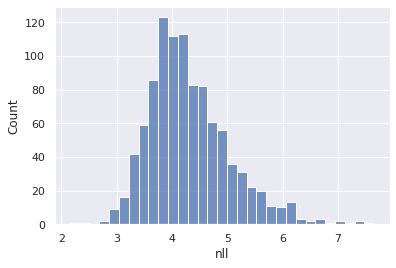

In [10]:
# Negative log likelihood distribution
sns.histplot(df['nll'])

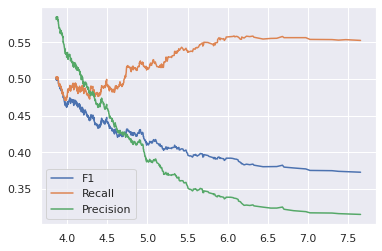

In [15]:
# ROUGE scores(rolling avegare) by negative log likelihood
window = 300
plt.plot(df_sorted['nll'], df_sorted['F1'].rolling(window=window).mean(), label='F1')
plt.plot(df_sorted['nll'], df_sorted['Recall'].rolling(window=window).mean(), label='Recall')
plt.plot(df_sorted['nll'], df_sorted['Precision'].rolling(window=window).mean(), label='Precision')

plt.legend()
plt.show()

In [12]:
# combine the data with length values from the next section

df

,nll,F1,Recall,Precision,dec_texts,ref_texts
0,3.719868,0.746269,0.595238,1.000000,to be able to see nobody ! and at that distanc...,"i see nobody on the road , ' said alice . ' i ..."
1,4.377326,0.235294,0.266667,0.210526,"maps are such shapes , with their islands and ...","this was charming , no doubt ; but they shortl..."
2,4.722786,0.410256,1.000000,0.258065,i know you by heart .\nyou are inside my heart...,i know you by heart . you are inside my heart .
3,3.839400,0.192308,0.188679,0.196078,"you never did ask each other anything , did yo...","she said she knew we were safe with you , and ..."
4,4.797490,0.412698,0.866667,0.270833,never underestimate the determination of a kid...,never underestimate the determination of a kid...
...,...,...,...,...,...,...
999,3.975476,0.218750,0.148936,0.411765,it seems so to me sometimes .\nthat will be aw...,stepan arkadyich smiled . he knew so well this...
1000,3.867302,0.185185,0.250000,0.147059,if our expectation of advantage be tempered in...,whether in an advantageous position or a disad...
1001,5.356282,0.391304,1.000000,0.243243,the body is literally manufactured and sustain...,the body is literally manufactured and sustain...
1002,3.622245,0.725664,0.594203,0.931818,she is always the .\na scandal in bohemia i. ....,to sherlock holmes she is always the woman . i...


In [13]:
df_sorted = df.sort_values(by='nll').reset_index(drop=True)

In [14]:
# reference and decoded text lengths by negative log likelihood
window = 100
plt.plot(df_sorted['nll'], df_sorted['ref_lengths'].rolling(window=window).mean(), label='ref_lengths')
plt.plot(df_sorted['nll'], df_sorted['dec_lengths'].rolling(window=window).mean(), label='dec_lengths')
#plt.plot(df_sorted['nll'], df_sorted['context_lengths'].rolling(window=window).mean(), label='context_lengths')

plt.legend()
plt.show()

KeyError: 'ref_lengths'

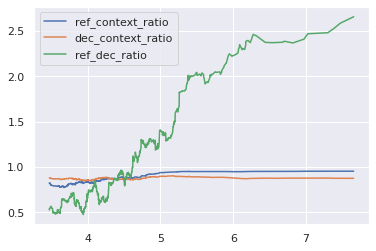

In [ ]:
# length ratios of texts by negative log likelihood
window = 100
plt.plot(df_sorted['nll'], df_sorted['ref_context_ratio'].rolling(window=window).mean(), label='ref_context_ratio')
plt.plot(df_sorted['nll'], df_sorted['dec_context_ratio'].rolling(window=window).mean(), label='dec_context_ratio')
plt.plot(df_sorted['nll'], df_sorted['ref_dec_ratio'].rolling(window=window).mean(), label='ref_dec_ratio')

plt.legend()
plt.show()

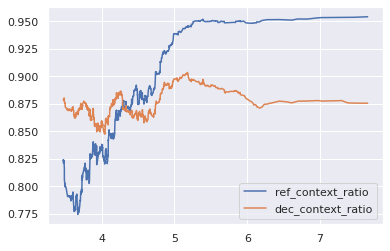

In [ ]:
# length ratios of texts by negative log likelihood
window = 100
plt.plot(df_sorted['nll'], df_sorted['ref_context_ratio'].rolling(window=window).mean(), label='ref_context_ratio')
plt.plot(df_sorted['nll'], df_sorted['dec_context_ratio'].rolling(window=window).mean(), label='dec_context_ratio')
#plt.plot(df_sorted['nll'], df_sorted['ref_dec_ratio'].rolling(window=window).mean(), label='ref_dec_ratio')

plt.legend()
plt.show()

# Rouge Scores by Length

In [2]:
import os
import config

from scipy import stats

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid')

In [3]:
# Define necessary directory paths for reference text and scores, obtain the file count.

data_name = "T50_T50"
data_path = "decode_" + data_name
log_name = os.path.join(config.log_root, data_path)

ref_dir = os.path.join(log_name, "rouge_ref")
dec_dir = os.path.join(log_name, "rouge_dec_dir")
scores_dir = os.path.join(log_name, "rouge_scores")

file_count = len(os.listdir(ref_dir))

In [4]:
# Obtain the score values for ROUGE1 from csv files.
df = pd.read_csv(os.path.join(scores_dir, 'rouge_1.csv'), usecols=['F1', 'Precision', 'Recall'])

In [5]:
# Get lengths from decoded and reference texts.
dec_lengths = []
ref_lengths = []
context_lengths = []
for i in range(len(os.listdir(ref_dir))):
    dec_file = os.path.join(dec_dir, str(i).zfill(6) + '_decoded.txt')
    ref_file = os.path.join(ref_dir, str(i).zfill(6) + '_reference.txt')

    with open(dec_file) as f:
        dec_lengths.append(len(f.read().split()))

    with open(ref_file) as f:
        ref_lengths.append(len(f.read().split()))

    context_dir = '../finished_files/data_T50/input_tokenized_dir/index_'+str(i)+'.txt'
    with open(context_dir) as f:
        context_lengths.append(len(f.readline().split()))


df['dec_lengths'] = dec_lengths
df['ref_lengths'] = ref_lengths
df['context_lengths'] = context_lengths

df['ref_context_ratio'] = df['ref_lengths']/df['context_lengths']
df['dec_context_ratio'] = abs(df['context_lengths']-df['dec_lengths'])/df['context_lengths']
df['ref_dec_ratio'] = abs(df['dec_lengths']-df['ref_lengths'])/df['ref_lengths']

df

,F1,Recall,Precision,dec_lengths,ref_lengths,context_lengths,ref_context_ratio,dec_context_ratio,ref_dec_ratio
0,0.746269,0.595238,1.000000,35,63,267,0.235955,0.868914,0.444444
1,0.235294,0.266667,0.210526,43,36,817,0.044064,0.947368,0.194444
2,0.410256,1.000000,0.258065,38,12,302,0.039735,0.874172,2.166667
3,0.192308,0.188679,0.196078,73,72,551,0.130672,0.867514,0.013889
4,0.412698,0.866667,0.270833,59,17,786,0.021628,0.924936,2.470588
...,...,...,...,...,...,...,...,...,...
999,0.218750,0.148936,0.411765,39,71,433,0.163972,0.909931,0.450704
1000,0.185185,0.250000,0.147059,41,21,547,0.038391,0.925046,0.952381
1001,0.391304,1.000000,0.243243,44,10,555,0.018018,0.920721,3.400000
1002,0.725664,0.594203,0.931818,60,115,590,0.194915,0.898305,0.478261


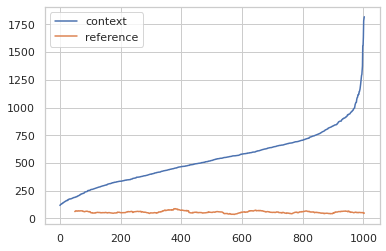

In [6]:
df_sorted = df.sort_values(by='context_lengths')
plt.plot(range(df.shape[0]),df_sorted['context_lengths'], label='context')
plt.plot(range(df.shape[0]), df_sorted['ref_lengths'].rolling(window=50).mean(), label='reference')
plt.legend()
plt.show()

In [7]:
df.describe()

,F1,Recall,Precision,dec_lengths,ref_lengths,context_lengths,ref_context_ratio,dec_context_ratio,ref_dec_ratio
count,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000
mean,0.435035,0.509465,0.449850,53.885458,56.850598,540.903386,0.133294,0.874004,1.051909
std,0.284220,0.338090,0.313518,17.270005,55.470844,239.892444,0.165111,0.089103,1.459745
min,0.000000,0.000000,0.000000,35.000000,5.000000,117.000000,0.006775,0.307692,0.000000
25%,0.190226,0.206897,0.183588,41.000000,23.000000,365.750000,0.041993,0.851279,0.281250
50%,0.353890,0.388861,0.358732,48.000000,38.000000,523.000000,0.078993,0.901193,0.578024
75%,0.682250,0.901190,0.705882,62.250000,71.250000,675.000000,0.157692,0.929286,1.226667
max,1.000000,1.000000,1.000000,100.000000,692.000000,1819.000000,1.773006,0.978567,15.200000


In [8]:
# Remove outliers
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

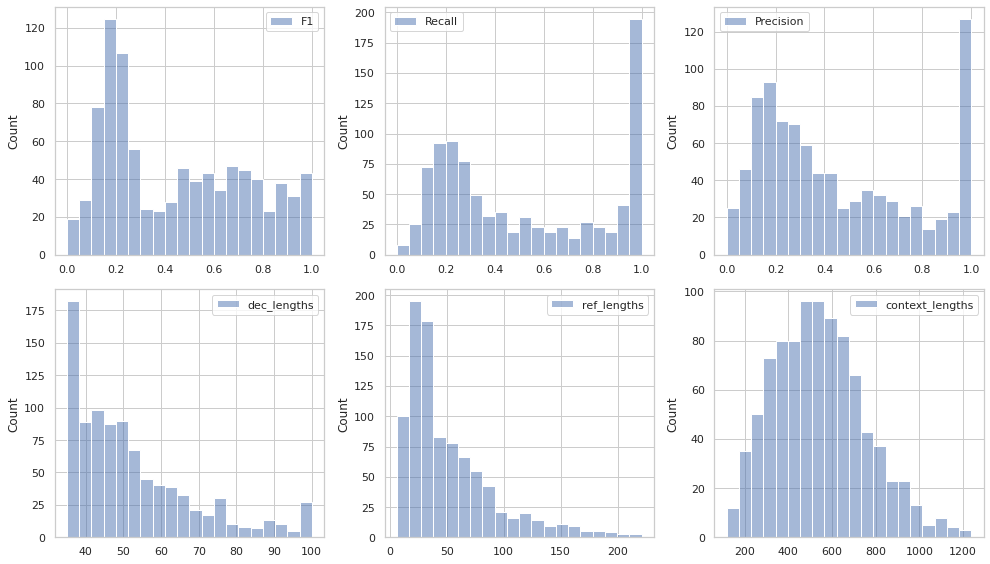

In [9]:
# Distributions of ROUGE scores and token length.

fig, ax = plt.subplots(2, 3, figsize=(14, 8))
col=0
for j in range(len(ax)):
    for i in range(len(ax[j])):
        sns.histplot(df.iloc[:, [col]], ax= ax[j, i], bins=20)
        col+=1
fig.tight_layout()
fig.show()


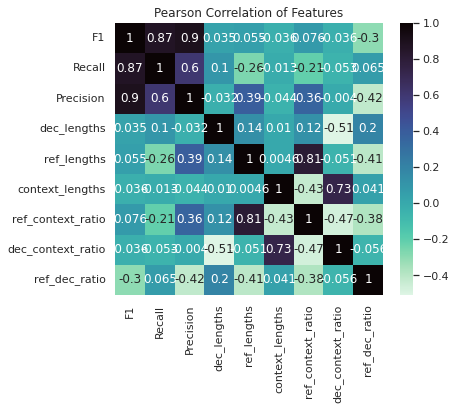

In [10]:
plt.figure(figsize=(6,5))
plt.title('Pearson Correlation of Features')
sns.heatmap(df.corr(), cmap = 'mako_r', annot = True)
plt.show()

In [11]:
from scipy.signal import lfilter
from scipy.signal import savgol_filter

In [34]:
n = 380  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1

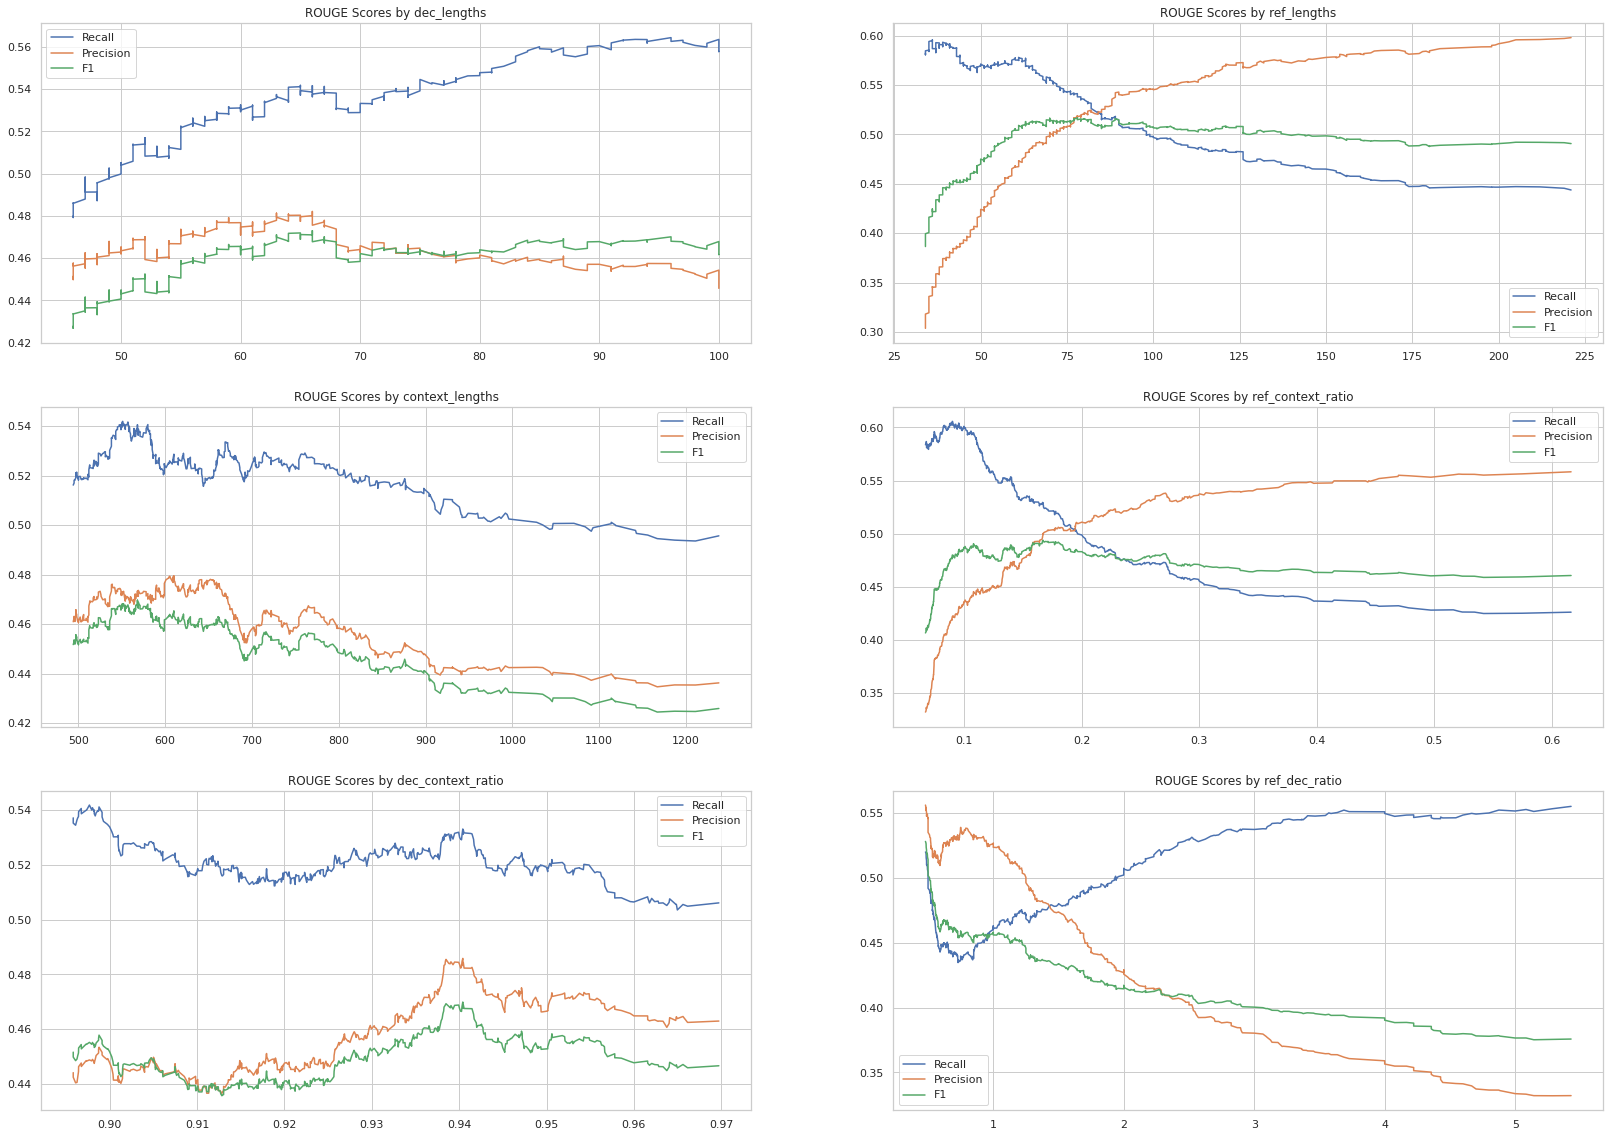

In [36]:
# results for df['ref_lengths']/df['context_lengths']

fig, ax = plt.subplots(3, 2, figsize=(28, 20))
columns=['dec_lengths', 'ref_lengths', 'context_lengths', 'ref_context_ratio', 'dec_context_ratio', 'ref_dec_ratio']
col_index = 0
for x in range(3):
    for y in range(2):
        for y_column in ['Recall', 'Precision', 'F1']:
            

            x_column = columns[col_index]
            df_sorted = df.sort_values(by=x_column)

            X = df_sorted[x_column]
            Y = df_sorted[y_column].rolling(window=400).mean()

            
            ax[x,y].plot(X, Y, label=y_column)
            ax[x,y].set_title('ROUGE Scores by {x_column}'.format(x_column=x_column, y_column=y_column))
            ax[x, y].legend()
        col_index += 1
        

plt.show()

In [7]:
from scipy.signal import lfilter
from scipy.signal import savgol_filter

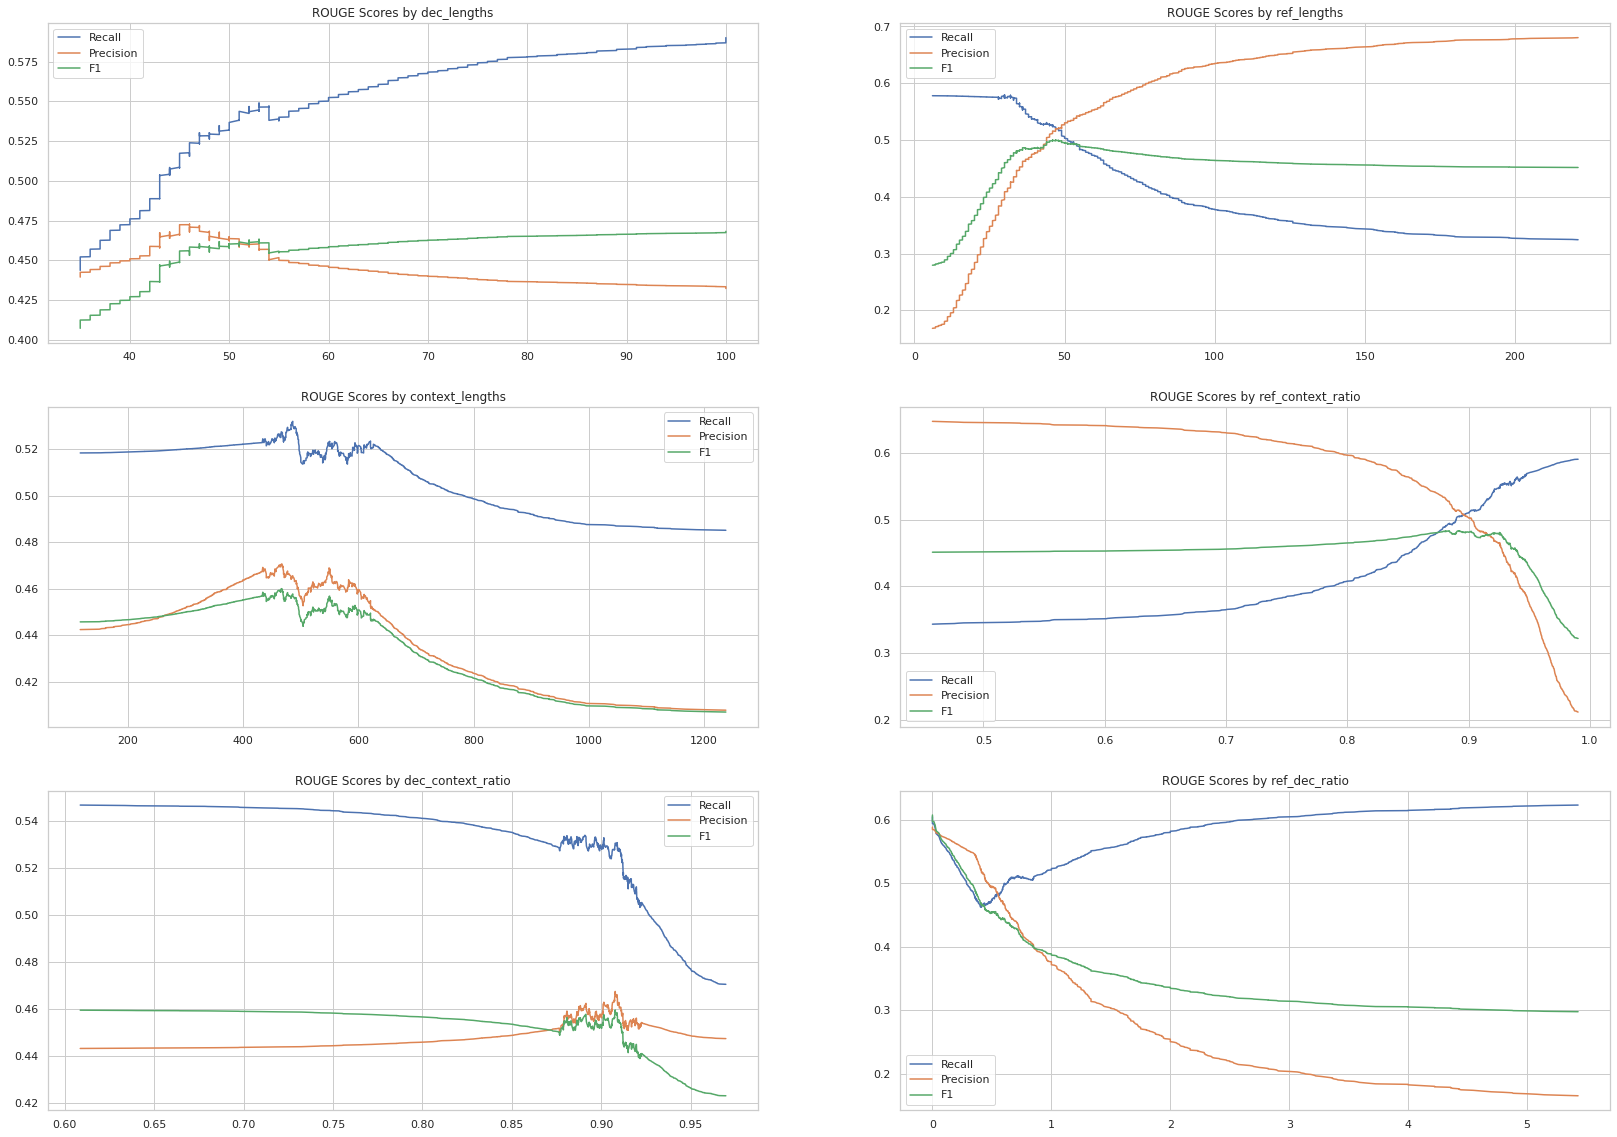

In [10]:
# results for abs(df['context_lengths']-df['ref_lengths'])/df['context_lengths']

fig, ax = plt.subplots(3, 2, figsize=(28, 20))
columns=['dec_lengths', 'ref_lengths', 'context_lengths', 'ref_context_ratio', 'dec_context_ratio', 'ref_dec_ratio']
col_index = 0
for x in range(3):
    for y in range(2):
        for y_column in ['Recall', 'Precision', 'F1']:
            

            x_column = columns[col_index]
            df_sorted = df.sort_values(by=x_column)

            X = df_sorted[x_column]
            Y = savgol_filter(df_sorted[y_column], 601, 1)

            
            ax[x,y].plot(X, Y, label=y_column)
            ax[x,y].set_title('ROUGE Scores by {x_column}'.format(x_column=x_column, y_column=y_column))
            ax[x, y].legend()
        col_index += 1
        

plt.show()

In [12]:
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

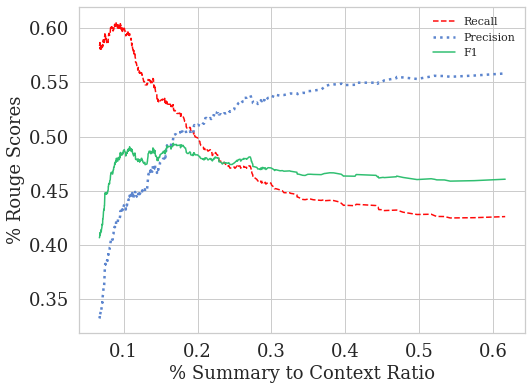

In [13]:
plt.style.context('default')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#ff0a0a', '#5c85ce', '#30bf71'])

fig = plt.figure(figsize=(8, 16))

df_sorted = df.sort_values(by='ref_context_ratio')
X = df_sorted['ref_context_ratio']
for linestyle, y_column in zip(['dashed', 'dotted', 'solid'],['Recall', 'Precision', 'F1']):
    Y = df_sorted[y_column].rolling(window=400).mean()
    if linestyle == 'dotted':
        plt.plot(X, Y, label=y_column, linestyle=linestyle, lw=2.5)
    else:
        plt.plot(X, Y, label=y_column, linestyle=linestyle)


plt.xlabel('% Summary to Context Ratio', fontsize=18)
plt.ylabel('% Rouge Scores', fontsize=18, color="black")
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.legend(frameon=False)
plt.show()